<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito+Sans&family=Quicksand&display=swap" rel="stylesheet">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0/css/all.min.css">


# FastVPINNs - Training Tutorial - Poisson Problem
---

In this notebook, we will try to understand, how to write FastVPINNs using Custom loss functions and custom neural networks. 

</div> 

Author : Thivin Anandh [Linkedin](https://linkedin.com/in/thivinanandh) [GitHub](https://github.com/thivinanandh) [Portfolio](https://thivinanandh.github.io) 

with Divij Ghose [Linkedin](https://www.linkedin.com/in/divij-ghose/) [GitHub](https://github.com/divijghose) [Website](https://divijghose.github.io)

For opening this notebook in google colab, please click on the button below.<br />
<br />
<a href="https://colab.research.google.com/github/cmgcds/fastvpinns/blob/main/examples/notebooks/poisson_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


</div>


## Installing FastVPINNs
---


To install FastVPINNs, you can use the following command.

```bash
pip install fastvpinns
```

For more information, please visit the Documentation [here](https://cmgcds.github.io/fastvpinns/)

In [ ]:
!pip install fastvpinns
!apt-get update
!apt-get install -y libglu1-mesa

## hp-Variational Physics-Informed Neural Networks (hp-VPINNs)
---

Variational Physics-Informed Neural Networks (VPINNs) are a special class of Physics-Informed Neural Networks (PINNs) that are trained using the variational formulation of the governing equations. Variational formulation us used in conventional numerical methods like Finite Element Method (FEM) to solve Partial Differential Equations (PDEs).  hp-VPINNs are a special class of VPINNs that uses the concepts of hp-FEM such as h- and p-refinement to improve the accuracy of the solution. h-refinement is the process of refining the mesh size, whereas p-refinement is the process of increasing the order of the basis functions. For more information, please refer the paper by Kharazmi et al. (2021) [here](https://www.sciencedirect.com/science/article/abs/pii/S0045782520307325).

The Simple formulation of hp-VPINNs is given by
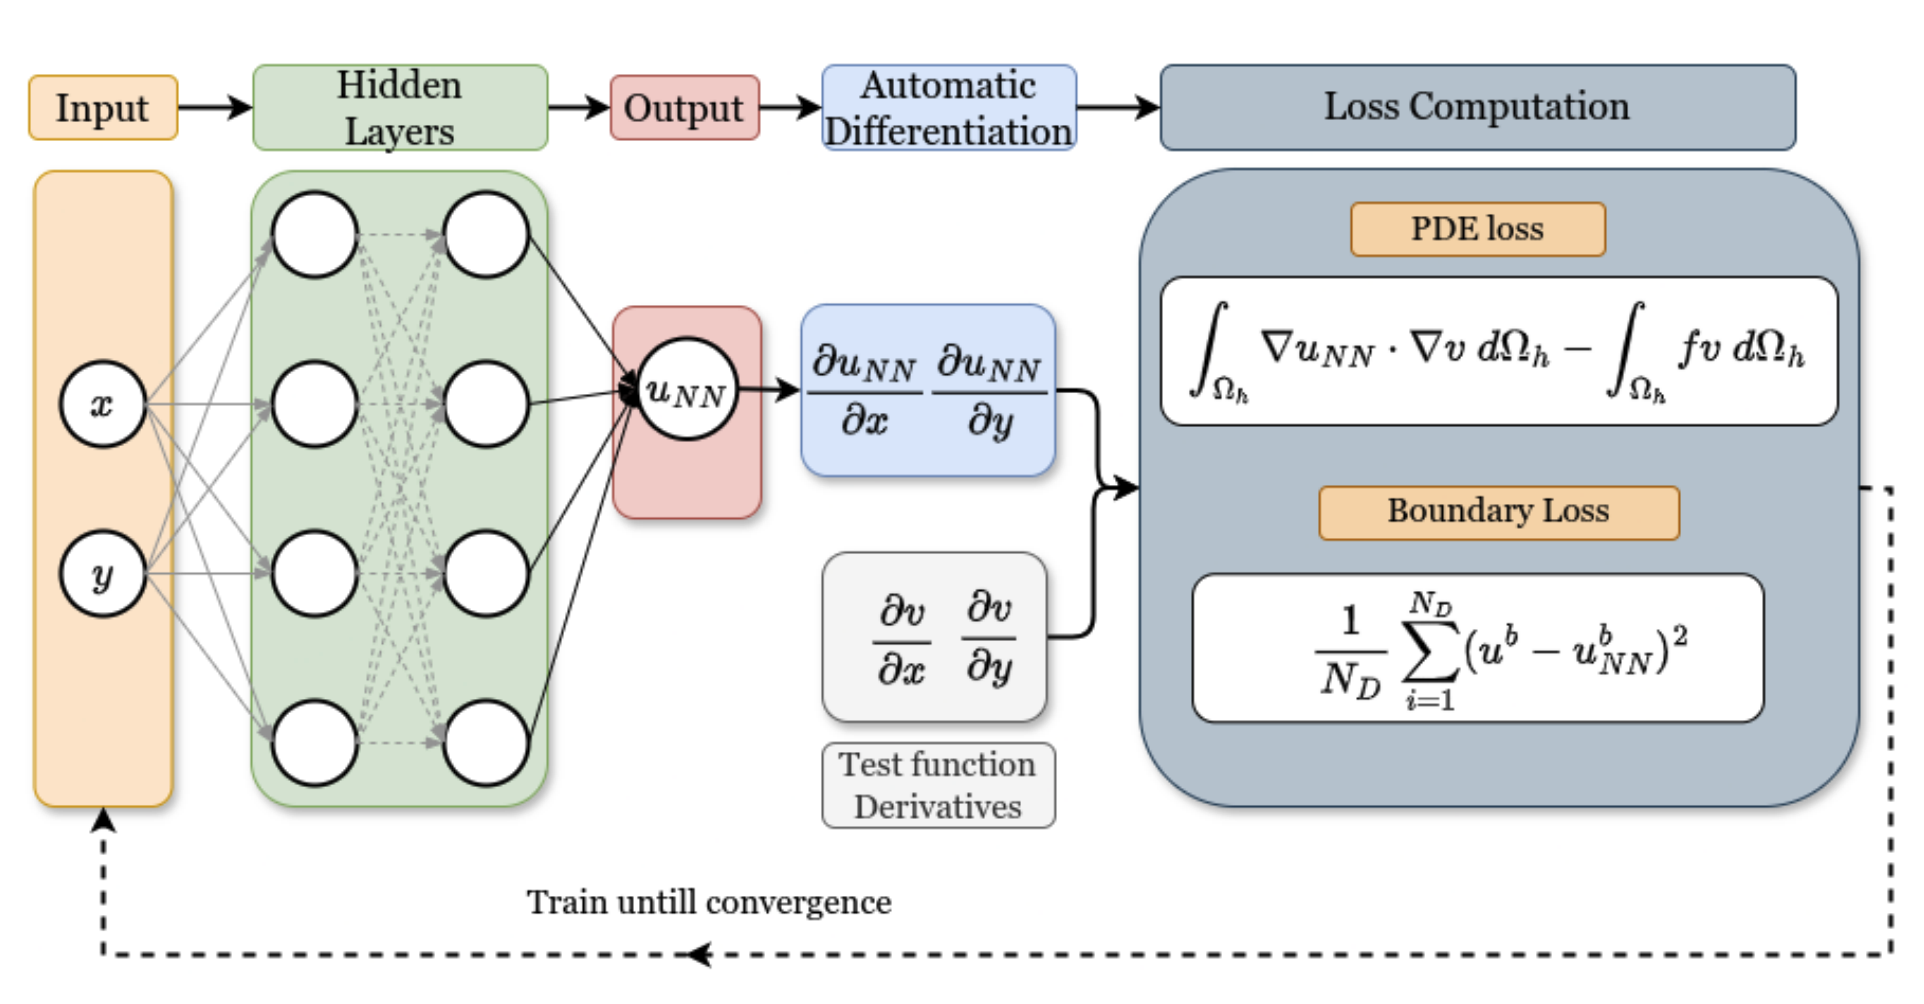


## Mathematical Formulation
---

Lets consider the 2D Poisson equation as an example. The Poisson equation is given by

$$
\nabla^2 u = f
$$

where $u$ is the solution, $f$ is the source term and $\nabla^2$ is the Laplacian operator. Now, in order to get the weak form of the Poisson equation, we multiply the equation by a test function $v$ and integrate over the domain $\Omega$.

$$
\int_{\Omega} \nabla^2 u v \, dx = \int_{\Omega} f v \, dx
$$

Now, lets apply integration by parts to the left hand side of the equation to get the weak form of the Poisson equation.

$$
\int_{\Omega} \nabla^2 u v \, dx = -\int_{\Omega} \nabla u \cdot \nabla v \, dx + \int_{\partial \Omega} \nabla u \cdot n v \, ds
$$

where $n$ is the normal vector to the boundary $\partial \Omega$.  The function $v$ is choosen such that $v = 0$ on the boundary $\partial \Omega$. Therefore, the boundary integral term becomes zero. Hence, the weak form of the Poisson equation is given by

$$

\int_{\Omega} \nabla u \cdot \nabla v \, dx = \int_{\Omega} f v \, dx
$$

Now, we can write the above equation in the variational form as

$$
\int_{\Omega} \nabla u \cdot \nabla v \, dx - \int_{\Omega} f v \, dx = 0
$$

with the dirichlet boundary condition $u = g$ on the boundary $\partial \Omega$. 

## Imports
---

Lets import the necessary functions for this tutorial from the FastVPINNs library.


In [1]:
# Common library imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import time
from tqdm import tqdm

# Fastvpinns Modules
from fastvpinns.Geometry.geometry_2d import Geometry_2D
from fastvpinns.FE.fespace2d import Fespace2D
from fastvpinns.data.datahandler2d import DataHandler2D


## Setting up Problem Parameters
---

In this section, we will setup all the parameters related to the Poisson problem such as Geometries, Test Function spaces, Neural Network Architectures, Learning Rates Etc

For Additional information on all Parameters , please refer the documentation [here](https://cmgcds.github.io/fastvpinns/)

### Geometry Parameters

- i_mesh_type : Type of mesh elements
- i_mesh_generation_method:  Internal mesh generation or external mesh
- i_n_test_points_x: Number of test points in x direction
- i_n_test_points_y: Number of test points in y direction
- i_output_path: Output path for the results
- i_x_min: Minimum value of x
- i_x_max: Maximum value of x
- i_y_min: Minimum value of y
- i_y_max: Maximum value of y
- i_n_cells_x: Number of cells in x direction
- i_n_cells_y: Number of cells in y direction
- i_n_boundary_points: Number of boundary points

### Finite Element Parameters

- i_fe_order: Order of the finite element basis functions
- i_fe_type: Type of the finite element basis functions
- i_quad_order: Order of the quadrature rule
- i_quad_type: Name of the quadrature rule
- i_fe_transform: Bilinear or Affine transformation
  
### Neural Network Parameters

- i_learning_rate_dict: Dictionary containing the learning rates for the neural networks
- i_data_type: Data type float32 or float64
- i_activation: Activation function for the neural networks


In [ ]:
i_mesh_type = "quadrilateral" # "quadrilateral"
i_mesh_generation_method = "internal" # "internal" or "external"
i_x_min = 0 # minimum x value
i_x_max = 1 # maximum x value
i_y_min = 0 # minimum y value
i_y_max = 1 # maximum y value
i_n_cells_x = 2 # Number of cells in the x direction
i_n_cells_y = 2 # Number of cells in the y direction
i_n_boundary_points = 400 # Number of points on the boundary
i_output_path = "output/poisson_2d" # Output path

i_n_test_points_x = 100 # Number of test points in the x direction
i_n_test_points_y = 100 # Number of test points in the y direction

# FE Variables
i_fe_order = 6 # Order of the finite element space
i_fe_type = "legendre"
i_quad_order = 10 # 10 points in 1D, so 100 points in 2D for one cell
i_quad_type = "gauss-jacobi"

# Neural Network Variables
i_learning_rate_dict = {
    "initial_learning_rate" : 0.001, # Initial learning rate
    "use_lr_scheduler" : False, # Use learning rate scheduler
    "decay_steps": 1000, # Decay steps
    "decay_rate": 0.96, # Decay rate
    "staircase": True, # Staircase Decay
}

i_dtype = tf.float32
i_activation = "tanh"
i_beta = 10 # Boundary Loss Penalty ( Adds more weight to the boundary loss)

# Epochs
i_num_epochs = 20000

## Setting up Boundary Conditions and Boundary Values 
---


In this section, we will setup the boundary conditions and boundary values for the Poisson problem. lets take an example, where the exact solution of the problem is given by

$$
u(x,y) =-1.0 \sin(2.0  \pi x) \sin(2.0 \pi y)
$$ 

The values of $u$ will be $0$ on the boundary $\partial \Omega$. The source term $f$  ( from method of manufactured solutions) is given by

$$
f(x,y) = -2(2.0\pi)^2 \sin(2.0\pi x) \sin(2.0\pi y)
$$

As per internal mesh generation, the boundary points are generated automatically.Further, the bottom boundary is assigned a tag of 1000, right boundary is assigned a tag of 1001, top boundary is assigned a tag of 1002 and left boundary is assigned a tag of 1003. The boundary conditions are given as follows


Currently, this library supports only Dirichlet Boundary Conditions. the Development branches of these versions have Neumann Boundary Conditions.

In [ ]:


def left_boundary(x, y):
    """
    This function will return the boundary value for given component of a boundary
    """
    val = 0.0
    return np.ones_like(x) * val


def right_boundary(x, y):
    """
    This function will return the boundary value for given component of a boundary
    """
    val = 0.0
    return np.ones_like(x) * val


def top_boundary(x, y):
    """
    This function will return the boundary value for given component of a boundary
    """
    val = 0.0
    return np.ones_like(x) * val


def bottom_boundary(x, y):
    """
    This function will return the boundary value for given component of a boundary
    """
    val = 0.0
    return np.ones_like(x) * val


def rhs(x, y):
    """
    This function will return the value of the rhs at a given point
    """
    omegaX = 2.0 * np.pi
    omegaY = 2.0 * np.pi
    f_temp = -2.0 * (omegaX**2) * (np.sin(omegaX * x) * np.sin(omegaY * y))

    return f_temp


def exact_solution(x, y):
    """
    This function will return the exact solution at a given point
    """
    # If the exact Solution does not have an analytical expression, leave the value as 0(zero)
    # it can be set using `np.ones_like(x) * 0.0` and then ignore the errors and the error plots generated.

    omegaX = 2.0 * np.pi
    omegaY = 2.0 * np.pi
    val = -1.0 * np.sin(omegaX * x) * np.sin(omegaY * y)

    return val


def get_boundary_function_dict():
    """
    This function will return a dictionary of boundary functions
    """
    return {1000: bottom_boundary, 1001: right_boundary, 1002: top_boundary, 1003: left_boundary}


def get_bound_cond_dict():
    """
    This function will return a dictionary of boundary conditions
    """
    return {1000: "dirichlet", 1001: "dirichlet", 1002: "dirichlet", 1003: "dirichlet"}


def get_bilinear_params_dict():
    """
    This function will return a dictionary of bilinear parameters
    """
    eps = 1.0

    return {"eps": eps}


### Create an Output Folder
---

In [4]:
## CREATE OUTPUT FOLDER
# use pathlib to create the folder,if it does not exist
folder = Path(i_output_path)
# create the folder if it does not exist
if not folder.exists():
    folder.mkdir(parents=True, exist_ok=True)

### Obtain the Boundary conditions and Boundary values


In [5]:
# get the boundary function dictionary from example file
bound_function_dict, bound_condition_dict = get_boundary_function_dict(), get_bound_cond_dict()



### Generate internal mesh


This calls the geometry module to generate the internal mesh and set up all cell and boundary information.

In [6]:
# Initiate a Geometry_2D object
domain = Geometry_2D(
    i_mesh_type, i_mesh_generation_method, i_n_test_points_x, i_n_test_points_y, i_output_path
)

# load the mesh
cells, boundary_points = domain.generate_quad_mesh_internal(
    x_limits=[i_x_min, i_x_max],
    y_limits=[i_y_min, i_y_max],
    n_cells_x=i_n_cells_x,
    n_cells_y=i_n_cells_y,
    num_boundary_points=i_n_boundary_points,
)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1000 (Line)
Info    : [ 30%] Meshing curve 1001 (Line)
Info    : [ 50%] Meshing curve 1002 (Line)
Info    : [ 80%] Meshing curve 1003 (Line)
Info    : Done meshing 1D (Wall 0.000868167s, CPU 0.0007s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.355005s, CPU 0.346038s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 0.000222417s, CPU 0.00016s)
Info    : 11833 nodes 23668 elements
Info    : Writing 'output/poisson_2d/internal.msh'...
[INFO] : Internal mesh file generated at  output/poisson_2d/internal.msh
Info    : Done writing 'output/poisson_2d/internal.msh'


Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to gmsh:dim_tags.

Warning: VTK ASCII files are only meant for debugging.

[INFO] : VTK file for internal mesh file generated at  output/poisson_2d/internal.msh


### Generate FE Space


This module is the core module of the library. It generates the finite element space and sets up the basis functions and quadrature rules. It preassembles the test function matrices for each cell and assigns boundary values to the boundary points.

In [ ]:
fespace = Fespace2D(
        mesh=domain.mesh,
        cells=cells,
        boundary_points=boundary_points,
        cell_type=domain.mesh_type,
        fe_order=i_fe_order,
        fe_type=i_fe_type,
        quad_order=i_quad_order,
        quad_type=i_quad_type,
        fe_transformation_type="bilinear",
        bound_function_dict=bound_function_dict,
        bound_condition_dict=bound_condition_dict,
        forcing_function=rhs,
        output_path=i_output_path,
        generate_mesh_plot=True,
    )

### Datahandler

This module is used to convert the data into tensorflow datasets. It also contains functions which assemble the test function and other values into tensor format, which will be used for training


In [8]:
# instantiate data handler
datahandler = DataHandler2D(fespace, domain, dtype=i_dtype)

params_dict = {}
params_dict['n_cells'] = fespace.n_cells

## Model 
---

In this section, we will use the neural Network module available within the FastVPINNs library to create and train the neural networks. They can be imported from the "model" module of fastvpinns. 

```python
fastvpinns.model.model import DenseModel
```

### Loss Function
---

The tensor based variational loss formulation for most of scalar problems can be imported from "physics" modules.

```python
from fastvpinns.physics.poisson2d import pde_loss_poisson
```



In [9]:
from fastvpinns.model.model import DenseModel
from fastvpinns.physics.poisson2d import pde_loss_poisson

params_dict = {}
params_dict['n_cells'] = fespace.n_cells

# get the input data for the PDE
train_dirichlet_input, train_dirichlet_output = datahandler.get_dirichlet_input()

# get bilinear parameters
# this function will obtain the values of the bilinear parameters from the model
# and convert them into tensors of desired dtype
bilinear_params_dict = datahandler.get_bilinear_params_dict_as_tensors(get_bilinear_params_dict)

model = DenseModel(
    layer_dims=[2, 30, 30, 30, 1],
    learning_rate_dict=i_learning_rate_dict,
    params_dict=params_dict,
    loss_function=pde_loss_poisson,
    input_tensors_list=[datahandler.x_pde_list, train_dirichlet_input, train_dirichlet_output],
    orig_factor_matrices=[
        datahandler.shape_val_mat_list,
        datahandler.grad_x_mat_list,
        datahandler.grad_y_mat_list,
    ],
    force_function_list=datahandler.forcing_function_list,
    tensor_dtype=i_dtype,
    activation=i_activation,
)

[INFO] : Total number of Dirichlet boundary points = 400
[INFO] : Shape of Dirichlet-X = (400, 2)
[INFO] : Shape of Y = (400, 1, 1)
--------------------------------------------------------------------------
| PARAMETER                 | SHAPE                     |
--------------------------------------------------------------------------
| input_tensor              | (1600, 2)                 | <dtype: 'float32'>
| force_matrix              | (36, 16)                  | <dtype: 'float32'>
| pre_multiplier_grad_x     | (16, 36, 100)             | <dtype: 'float32'>
| pre_multiplier_grad_y     | (16, 36, 100)             | <dtype: 'float32'>
| pre_multiplier_val        | (16, 36, 100)             | <dtype: 'float32'>
| dirichlet_input           | (400, 2)                  | <dtype: 'float32'>
| dirichlet_actual          | (400, 1)                  | <dtype: 'float32'>
--------------------------------------------------------------------------
Model: "dense_model"
_________________________

## Train the model
---

Now, we will train the model to solve the Poisson problem using the custom loss function and custom neural network model.

In [ ]:
loss_array = []  # total loss
time_array = []  # time taken for each epoch


for epoch in tqdm(range(i_num_epochs)):
        # Train the model
        batch_start_time = time.time()
        loss = model.train_step(beta=i_beta, bilinear_params_dict=bilinear_params_dict)
        elapsed = time.time() - batch_start_time

        # print(elapsed)
        time_array.append(elapsed)

        loss_array.append(loss['loss'])

## Visualise loss and Results
---


In [ ]:
# predict the values for the test points
test_points = domain.get_test_points()
print(f"[bold]Number of Test Points = [/bold] {test_points.shape[0]}")
y_exact = exact_solution(test_points[:, 0], test_points[:, 1])

# Get predicted values from the model
y_pred = model(test_points).numpy()
y_pred = y_pred.reshape(-1)

# compute the error
error = np.abs(y_exact - y_pred)

# plot a 2x2 Grid, loss plot, exact solution, predicted solution and error
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# loss plot
axs[0, 0].plot(loss_array)
axs[0, 0].set_title("Loss Plot")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_yscale("log")

# exact solution
# contour plot of the exact solution
axs[0, 1].tricontourf(test_points[:, 0], test_points[:, 1], y_exact, 100)
axs[0, 1].set_title("Exact Solution")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
# add colorbar
cbar = plt.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])


# predicted solution
# contour plot of the predicted solution
axs[1, 0].tricontourf(test_points[:, 0], test_points[:, 1], y_pred, 100)
axs[1, 0].set_title("Predicted Solution")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")
# add colorbar
cbar = plt.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

# error plot
# contour plot of the error
axs[1, 1].tricontourf(test_points[:, 0], test_points[:, 1], error, 100)
axs[1, 1].set_title("Error")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
# add colorbar
cbar = plt.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])


plt.tight_layout()


# print error statistics
l2_error = np.sqrt(np.mean(error ** 2))
l1_error = np.mean(np.abs(error))
l_inf_error = np.max(np.abs(error))
rel_l2_error = l2_error / np.sqrt(np.mean(y_exact ** 2))
rel_l1_error = l1_error / np.mean(np.abs(y_exact))
rel_l_inf_error = l_inf_error / np.max(np.abs(y_exact))

# print the error statistics in a formatted table
error_df = pd.DataFrame(
    {
        "L2 Error": [l2_error],
        "L1 Error": [l1_error],
        "L_inf Error": [l_inf_error],
        "Relative L2 Error": [rel_l2_error],
        "Relative L1 Error": [rel_l1_error],
        "Relative L_inf Error": [rel_l_inf_error],
    }
)
print(error_df)

